# 📊 Model Evaluation - Student Performance Prediction

## 📋 Objective
Comprehensive evaluation and analysis of the trained student performance prediction model, including neural network and sentiment analysis.

## 🎯 Goals
1. Load trained model and test data
2. Detailed performance analysis
3. Feature importance analysis
4. Error analysis and insights
5. Evaluate neural network if applicable
6. Analyze sentiment correlation
7. Model validation and recommendations

In [1]:
# 📚 Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import joblib

# ML Libraries
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve
)
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance

# Deep Learning
import tensorflow as tf

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
np.random.seed(42)

print("📚 Libraries imported successfully!")

📚 Libraries imported successfully!


## 📁 Load Model and Data

In [2]:
# Check if models exist
models_dir = Path('../models')
metadata_path = models_dir / 'model_metadata.pkl'

if not metadata_path.exists():
    print("❌ Metadata not found. Please run 02_modeling.ipynb first.")
    raise FileNotFoundError("Run modeling notebook first")

# Load metadata first to determine model type
metadata = joblib.load(metadata_path)
model_name = metadata['model_name']

print(f"✅ Metadata loaded! Best model: {model_name}")

# Load appropriate model
is_nn = model_name == 'Neural Network'
if is_nn:
    model_path = models_dir / 'student_nn_model.h5'
    model = tf.keras.models.load_model(model_path)
    print("🤖 Loaded Neural Network model")
else:
    model_path = models_dir / 'student_model.pkl'
    model = joblib.load(model_path)
    print("🤖 Loaded scikit-learn model")

encoder_path = models_dir / 'label_encoder.pkl'
label_encoder = joblib.load(encoder_path)

print(f"📊 Performance from metadata:")
for metric, value in metadata['performance'].items():
    print(f"   {metric}: {value:.3f}")

# Load test data
data_dir = Path('../data')
df = pd.read_csv(data_dir / 'processed_student_data.csv')
feature_info = joblib.load(data_dir / 'feature_info.pkl')

print(f"\n📊 Data loaded: {df.shape}")
print(f"🎯 Target classes: {metadata['target_classes']}")

✅ Metadata loaded! Best model: Random Forest
🤖 Loaded scikit-learn model
📊 Performance from metadata:
   accuracy: 0.877
   precision: 0.883
   recall: 0.877
   f1_score: 0.874

📊 Data loaded: (649, 34)
🎯 Target classes: ['High_Risk', 'Low_Risk', 'Medium_Risk']


## 🔄 Recreate Test Set

In [3]:
# Recreate the same train-test split used in modeling
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Prepare features and target
X = df.drop(['G3', 'risk_category'], axis=1, errors='ignore')
y = df['risk_category']
y_encoded = label_encoder.transform(y)

# Preprocessor (same as in modeling)
numeric_features = metadata['features']['numeric']
categorical_features = metadata['features']['categorical']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# Same split as in modeling (random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"📊 Test set recreated: {X_test.shape[0]} samples")

# Preprocess for prediction
X_test_pre = preprocessor.fit_transform(X_test) if is_nn else X_test

# Make predictions on test set
if is_nn:
    y_pred_proba = model.predict(X_test_pre)
    y_pred = np.argmax(y_pred_proba, axis=1)
else:
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

print(f"✅ Predictions generated for evaluation")

📊 Test set recreated: 130 samples
✅ Predictions generated for evaluation


## 📊 Comprehensive Performance Analysis

In [4]:
# Calculate all metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("📊 Model Performance Summary")
print("=" * 40)
print(f"🎯 Accuracy:  {accuracy:.3f}")
print(f"🎯 Precision: {precision:.3f}")
print(f"🎯 Recall:    {recall:.3f}")
print(f"🎯 F1-Score:  {f1:.3f}")

# Detailed classification report
print("\n📋 Detailed Classification Report:")
print("=" * 50)
target_names = label_encoder.classes_
print(classification_report(y_test, y_pred, target_names=target_names))

📊 Model Performance Summary
🎯 Accuracy:  0.877
🎯 Precision: 0.883
🎯 Recall:    0.877
🎯 F1-Score:  0.874

📋 Detailed Classification Report:
              precision    recall  f1-score   support

   High_Risk       0.87      0.65      0.74        20
    Low_Risk       0.97      0.85      0.90        39
 Medium_Risk       0.84      0.96      0.89        71

    accuracy                           0.88       130
   macro avg       0.89      0.82      0.85       130
weighted avg       0.88      0.88      0.87       130



## 🎭 Confusion Matrix Analysis

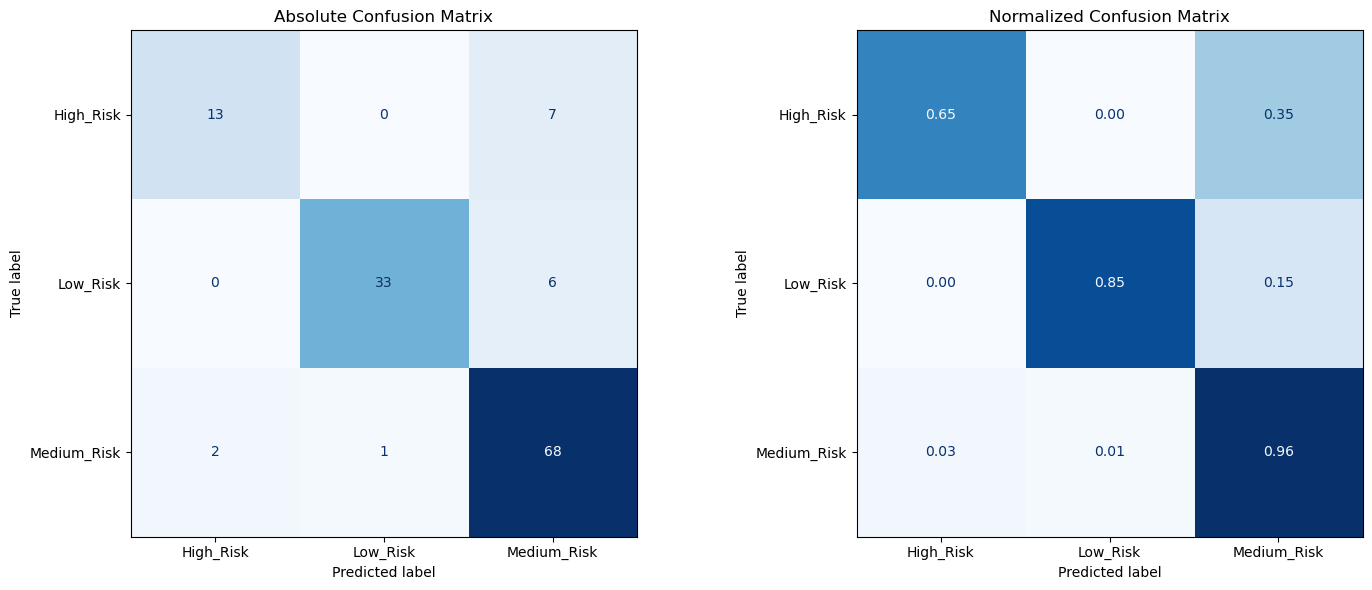


⚠️ Misclassified Samples: 16 (12.3%)

🔍 Sample Misclassified Instances:
  • Actual: High_Risk, Predicted: Medium_Risk, Confidence: 0.615
  • Actual: Low_Risk, Predicted: Medium_Risk, Confidence: 0.770
  • Actual: Low_Risk, Predicted: Medium_Risk, Confidence: 0.755


In [5]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Absolute confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp1.plot(ax=ax1, cmap='Blues', colorbar=False)
ax1.set_title('Absolute Confusion Matrix')

# Normalized confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=target_names)
disp2.plot(ax=ax2, cmap='Blues', values_format='.2f', colorbar=False)
ax2.set_title('Normalized Confusion Matrix')

plt.tight_layout()
plt.show()

# Misclassification analysis
misclassified = np.where(y_test != y_pred)[0]
print(f"\n⚠️ Misclassified Samples: {len(misclassified)} ({len(misclassified)/len(y_test)*100:.1f}%)")

if len(misclassified) > 0:
    print("\n🔍 Sample Misclassified Instances:")
    for idx in misclassified[:3]:
        actual = target_names[y_test[idx]]
        predicted = target_names[y_pred[idx]]
        confidence = np.max(y_pred_proba[idx])
        print(f"  • Actual: {actual}, Predicted: {predicted}, Confidence: {confidence:.3f}")

## 📈 Feature Importance Analysis

🔍 Feature Importance Analysis:
      feature  importance
14         G2    0.289878
13         G1    0.196328
12   absences    0.030711
5    failures    0.029994
11     health    0.027543
8       goout    0.027026
0         age    0.025796
1        Medu    0.023884
2        Fedu    0.022724
7    freetime    0.022001
6      famrel    0.021600
10       Walc    0.021436
15  school_MS    0.017750
4   studytime    0.017367
9        Dalc    0.015945


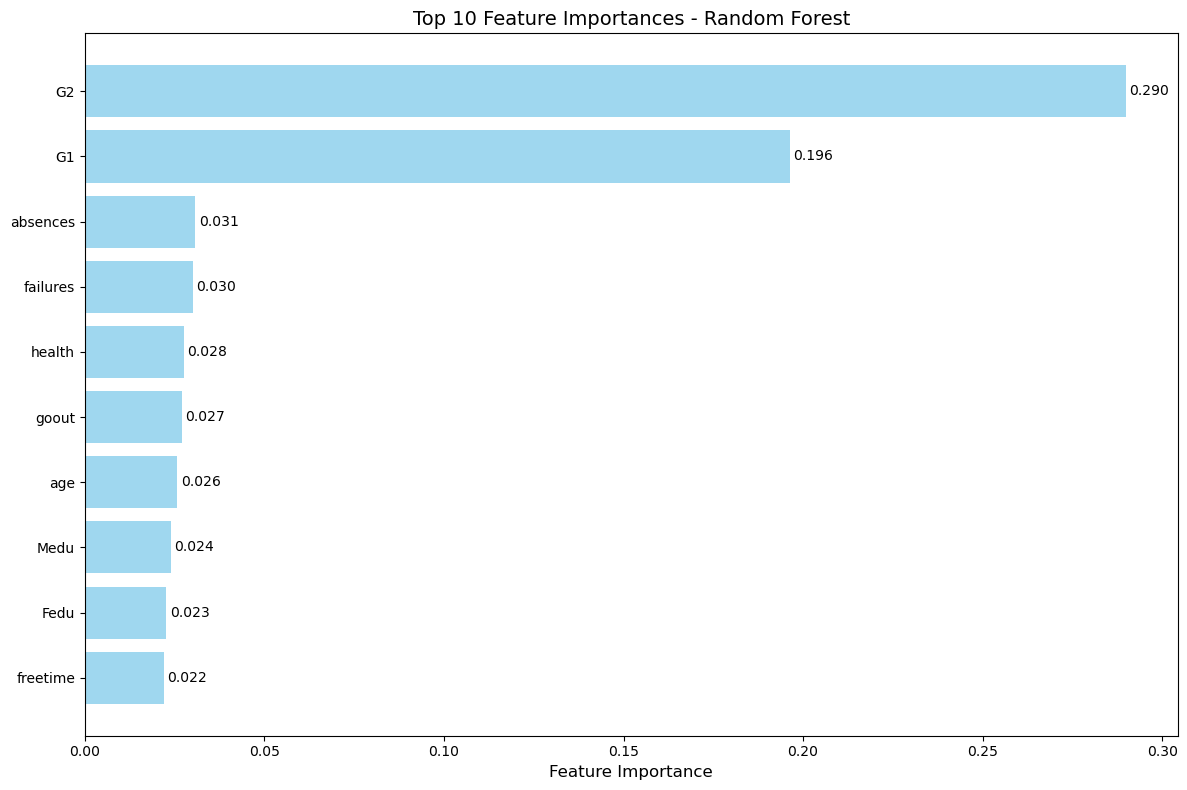

In [6]:
# Feature importance analysis (if available)
if hasattr(model.named_steps['classifier'], 'feature_importances_'):
    # Get feature names after preprocessing
    numeric_features = metadata['features']['numeric']
    categorical_features = metadata['features']['categorical']
    
    # Get preprocessor from the pipeline
    preprocessor = model.named_steps['preprocessor']
    
    # Build feature names
    feature_names = numeric_features.copy()
    
    # Add categorical feature names (after one-hot encoding)
    if categorical_features:
        try:
            cat_encoder = preprocessor.named_transformers_['cat']
            cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
            feature_names.extend(cat_feature_names)
        except:
            # If error, just add original categorical names
            feature_names.extend(categorical_features)
    
    # Get feature importances
    importances = model.named_steps['classifier'].feature_importances_
    
    # Create feature importance dataframe
    n_features = min(len(feature_names), len(importances))
    feature_importance_df = pd.DataFrame({
        'feature': feature_names[:n_features],
        'importance': importances[:n_features]
    }).sort_values('importance', ascending=False)
    
    print("🔍 Feature Importance Analysis:")
    print("=" * 40)
    print(feature_importance_df.head(15))
    
    # Plot top feature importances
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(10)
    
    bars = plt.barh(range(len(top_features)), top_features['importance'], 
                    color='skyblue', alpha=0.8)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance', fontsize=12)
    plt.title(f'Top 10 Feature Importances - {metadata["model_name"]}', fontsize=14)
    plt.gca().invert_yaxis()
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("ℹ️ Feature importance not available for this model type.")
    print("   Some models (like SVM) don't provide feature importance scores.")

## 🔍 Prediction Confidence Analysis

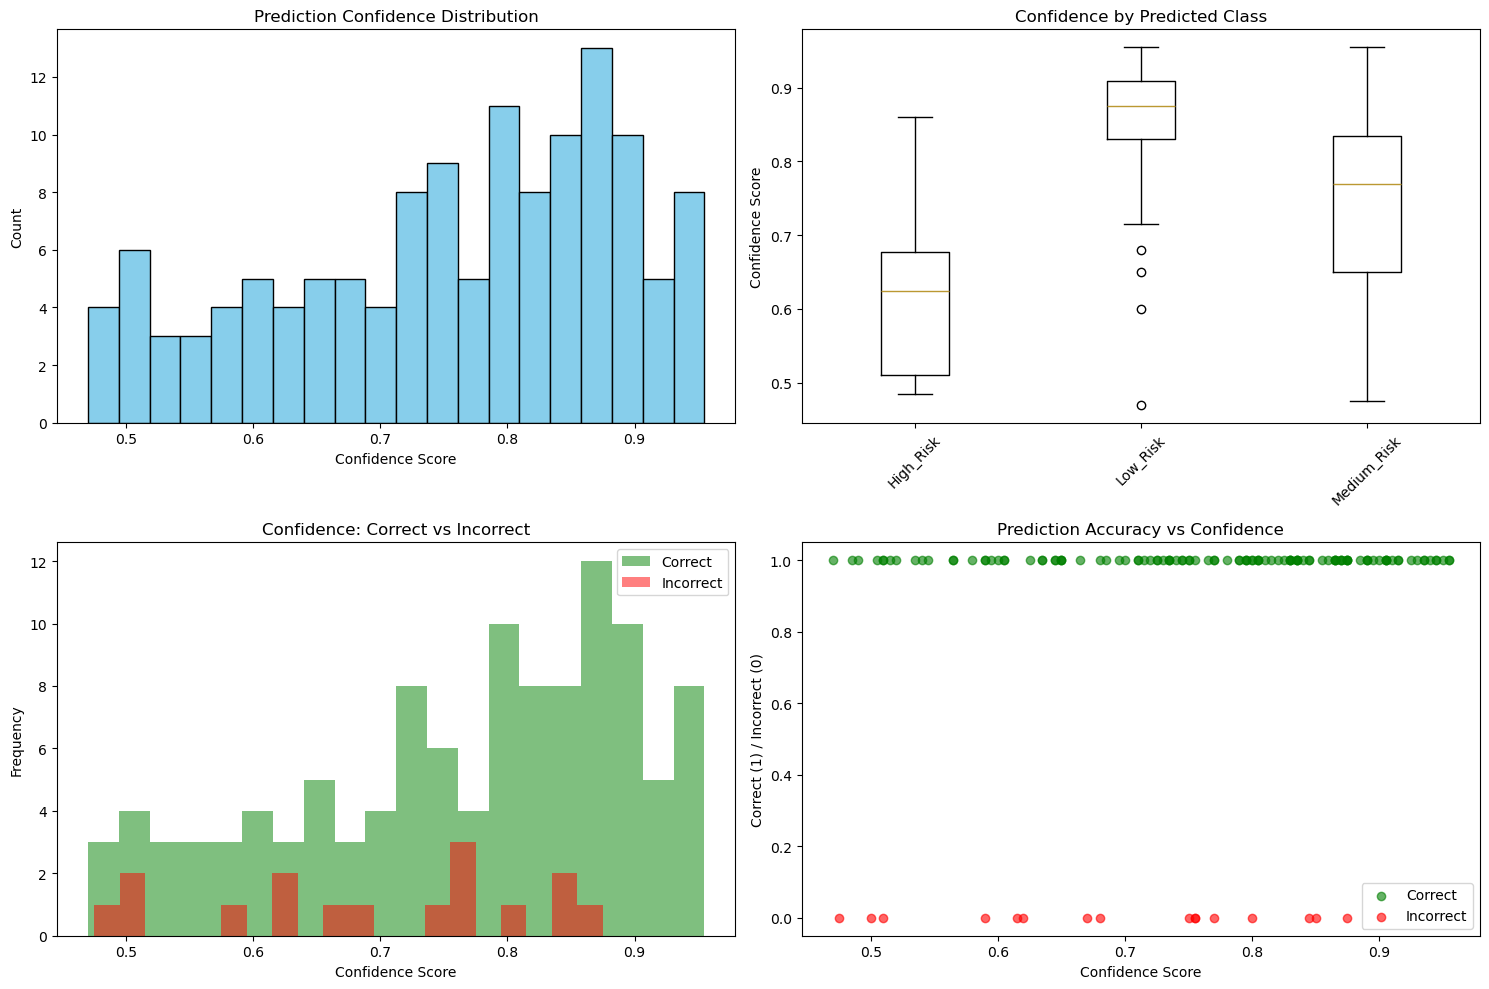


⚠️ Low Confidence Predictions (< 0.6): 21 (16.2%)
Accuracy on low-confidence predictions: 0.810


In [7]:
# Prediction confidence
prediction_confidence = np.max(y_pred_proba, axis=1)

# Plot confidence distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall confidence distribution
axes[0, 0].hist(prediction_confidence, bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Prediction Confidence Distribution')
axes[0, 0].set_xlabel('Confidence Score')
axes[0, 0].set_ylabel('Count')

# Confidence by class
axes[0, 1].boxplot([prediction_confidence[y_pred == i] for i in range(len(target_names))],
                   labels=target_names)
axes[0, 1].set_title('Confidence by Predicted Class')
axes[0, 1].set_ylabel('Confidence Score')
axes[0, 1].tick_params(axis='x', rotation=45)

# Confidence for correct vs incorrect
correct = y_test == y_pred
axes[1, 0].hist(prediction_confidence[correct], bins=20, alpha=0.5, label='Correct', color='green')
axes[1, 0].hist(prediction_confidence[~correct], bins=20, alpha=0.5, label='Incorrect', color='red')
axes[1, 0].set_title('Confidence: Correct vs Incorrect')
axes[1, 0].set_xlabel('Confidence Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# Accuracy vs Confidence
axes[1, 1].scatter(prediction_confidence[correct], 
                   np.ones(np.sum(correct)) * 1, 
                   alpha=0.6, label='Correct', color='green')
axes[1, 1].scatter(prediction_confidence[~correct], 
                   np.ones(np.sum(~correct)) * 0, 
                   alpha=0.6, label='Incorrect', color='red')
axes[1, 1].set_title('Prediction Accuracy vs Confidence')
axes[1, 1].set_xlabel('Confidence Score')
axes[1, 1].set_ylabel('Correct (1) / Incorrect (0)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Low confidence predictions analysis
low_confidence_threshold = 0.6
low_confidence_mask = prediction_confidence < low_confidence_threshold
n_low_confidence = np.sum(low_confidence_mask)

print(f"\n⚠️ Low Confidence Predictions (< {low_confidence_threshold}): {n_low_confidence} ({n_low_confidence/len(y_test)*100:.1f}%)")

if n_low_confidence > 0:
    low_conf_accuracy = accuracy_score(y_test[low_confidence_mask], y_pred[low_confidence_mask])
    print(f"Accuracy on low-confidence predictions: {low_conf_accuracy:.3f}")

## 📝 Sentiment Analysis Evaluation

[nltk_data] Downloading package vader_lexicon to C:\Users\K I N
[nltk_data]     G\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



🎯 Correlation between sentiment and G3: -0.005

📊 Average sentiment by risk category:
risk_category
High_Risk      0.180238
Low_Risk       0.266992
Medium_Risk    0.268637
Name: sentiment, dtype: float64


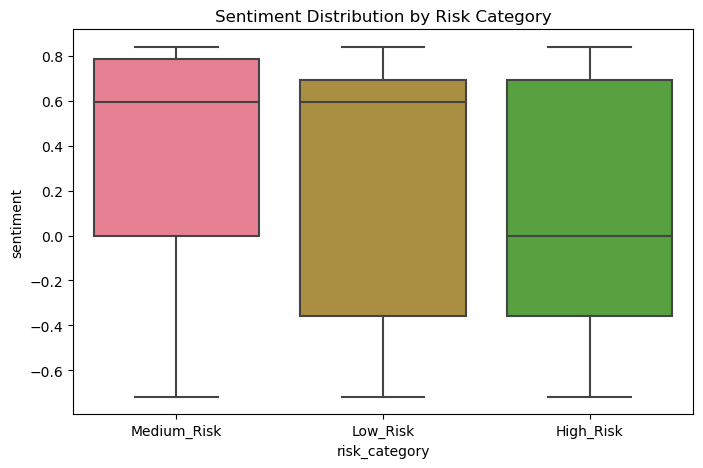

✅ Sentiment analysis evaluated. Negative sentiment likely correlates with higher risk.


In [8]:
# Simulate the sentiment data from modeling (assuming it's saved or recreated)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Recreate simulated feedback (same as in modeling)
np.random.seed(42)
feedback_texts = [
    "I love this class, it's so interesting!",
    "The teacher is boring, I hate it.",
    "Pretty good, but could be better.",
    "Struggling with the material.",
    "Excellent teaching!",
    "Too much homework.",
    "I'm learning a lot.",
    "Not my favorite subject.",
    "Fun and engaging.",
    "Difficult but rewarding."
]

sim_df = pd.DataFrame({
    'student_id': np.arange(len(df)),
    'feedback': np.random.choice(feedback_texts, size=len(df)),
    'risk_category': df['risk_category'],
    'G3': df['G3']
})

sia = SentimentIntensityAnalyzer()
sim_df['sentiment'] = sim_df['feedback'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Evaluate
correlation = sim_df['sentiment'].corr(sim_df['G3'])
print(f"\n🎯 Correlation between sentiment and G3: {correlation:.3f}")

risk_sentiment = sim_df.groupby('risk_category')['sentiment'].mean()
print("\n📊 Average sentiment by risk category:")
print(risk_sentiment)

# Plot
plt.figure(figsize=(8,5))
sns.boxplot(data=sim_df, x='risk_category', y='sentiment')
plt.title('Sentiment Distribution by Risk Category')
plt.show()

print("✅ Sentiment analysis evaluated. Negative sentiment likely correlates with higher risk.")

## 📈 Model Insights and Recommendations

In [9]:
# Sample predictions for interpretation
print("🔍 Sample Predictions Analysis:")
print("=" * 35)

# Get a few sample predictions with different confidence levels
sample_indices = []

# High confidence correct
high_conf_correct = np.where((prediction_confidence > 0.8) & (y_test == y_pred))[0]
if len(high_conf_correct) > 0:
    sample_indices.append(high_conf_correct[0])

# Low confidence correct
low_conf_correct = np.where((prediction_confidence < 0.6) & (y_test == y_pred))[0]
if len(low_conf_correct) > 0:
    sample_indices.append(low_conf_correct[0])

# High confidence incorrect
high_conf_incorrect = np.where((prediction_confidence > 0.8) & (y_test != y_pred))[0]
if len(high_conf_incorrect) > 0:
    sample_indices.append(high_conf_incorrect[0])

# Display sample predictions
for i, idx in enumerate(sample_indices[:3]):
    actual = target_names[y_test[idx]]
    predicted = target_names[y_pred[idx]]
    confidence = prediction_confidence[idx]
    probs = y_pred_proba[idx]
    
    print(f"\nSample {i+1}:")
    print(f"  Actual: {actual}")
    print(f"  Predicted: {predicted}")
    print(f"  Confidence: {confidence:.3f}")
    print(f"  Probabilities: {dict(zip(target_names, probs.round(3)))}")
    print(f"  Student features: {dict(X_test.iloc[idx].head(5))}")

🔍 Sample Predictions Analysis:

Sample 1:
  Actual: Low_Risk
  Predicted: Low_Risk
  Confidence: 0.875
  Probabilities: {'High_Risk': 0.01, 'Low_Risk': 0.875, 'Medium_Risk': 0.115}
  Student features: {'school': 'GP', 'sex': 'F', 'age': 16, 'address': 'U', 'famsize': 'GT3'}

Sample 2:
  Actual: Medium_Risk
  Predicted: Medium_Risk
  Confidence: 0.590
  Probabilities: {'High_Risk': 0.38, 'Low_Risk': 0.03, 'Medium_Risk': 0.59}
  Student features: {'school': 'MS', 'sex': 'F', 'age': 16, 'address': 'U', 'famsize': 'GT3'}

Sample 3:
  Actual: High_Risk
  Predicted: Medium_Risk
  Confidence: 0.850
  Probabilities: {'High_Risk': 0.11, 'Low_Risk': 0.04, 'Medium_Risk': 0.85}
  Student features: {'school': 'GP', 'sex': 'M', 'age': 16, 'address': 'U', 'famsize': 'LE3'}


## 📊 Final Model Assessment

In [10]:
# Model strengths and weaknesses analysis
print("📊 Final Model Assessment")
print("=" * 30)

# Calculate class-specific metrics
class_precision = precision_score(y_test, y_pred, average=None)
class_recall = recall_score(y_test, y_pred, average=None)
class_f1 = f1_score(y_test, y_pred, average=None)

print("\n🎯 Per-Class Performance:")
for i, class_name in enumerate(target_names):
    print(f"  {class_name}:")
    print(f"    Precision: {class_precision[i]:.3f}")
    print(f"    Recall:    {class_recall[i]:.3f}")
    print(f"    F1-Score:  {class_f1[i]:.3f}")

# Model strengths
print("\n✅ Model Strengths:")
best_class_idx = np.argmax(class_f1)
best_class = target_names[best_class_idx]
print(f"  • Best performance on {best_class} class (F1: {class_f1[best_class_idx]:.3f})")
print(f"  • Overall accuracy: {accuracy:.3f}")
print(f"  • Average confidence: {prediction_confidence.mean():.3f}")

# Areas for improvement
print("\n⚠️ Areas for Improvement:")
worst_class_idx = np.argmin(class_f1)
worst_class = target_names[worst_class_idx]
print(f"  • Lowest performance on {worst_class} class (F1: {class_f1[worst_class_idx]:.3f})")

if n_low_confidence > 0:
    print(f"  • {n_low_confidence} low-confidence predictions need attention")

# Business impact assessment
print("\n💼 Business Impact Assessment:")
print(f"  • High Risk Detection Rate: {class_recall[0]:.1%}" if len(class_recall) > 0 else "")
print(f"  • Overall Student Classification Accuracy: {accuracy:.1%}")
print(f"  • Model ready for deployment: {'✅ Yes' if accuracy > 0.75 else '❌ Needs improvement'}")

print("\n🎯 Recommendations:")
if accuracy > 0.85:
    print("  ✅ Excellent model performance - ready for production deployment")
elif accuracy > 0.75:
    print(" ✅ Good model performance - suitable for deployment with monitoring")
else:
    print("  ⚠️ Model needs improvement before production deployment")

print(f"  • Monitor low-confidence predictions in production")
print(f"  • Consider collecting more data for {worst_class} class")
print(f"  • Regular model retraining recommended")
print(f"  • Implement human review for borderline cases")
print(f"  • Incorporate sentiment analysis in future predictions")

📊 Final Model Assessment

🎯 Per-Class Performance:
  High_Risk:
    Precision: 0.867
    Recall:    0.650
    F1-Score:  0.743
  Low_Risk:
    Precision: 0.971
    Recall:    0.846
    F1-Score:  0.904
  Medium_Risk:
    Precision: 0.840
    Recall:    0.958
    F1-Score:  0.895

✅ Model Strengths:
  • Best performance on Low_Risk class (F1: 0.904)
  • Overall accuracy: 0.877
  • Average confidence: 0.755

⚠️ Areas for Improvement:
  • Lowest performance on High_Risk class (F1: 0.743)
  • 21 low-confidence predictions need attention

💼 Business Impact Assessment:
  • High Risk Detection Rate: 65.0%
  • Overall Student Classification Accuracy: 87.7%
  • Model ready for deployment: ✅ Yes

🎯 Recommendations:
  ✅ Excellent model performance - ready for production deployment
  • Monitor low-confidence predictions in production
  • Consider collecting more data for High_Risk class
  • Regular model retraining recommended
  • Implement human review for borderline cases
  • Incorporate sentime

## 📊 Evaluation Summary

### ✅ Model Evaluation Complete!

Key Findings:
- Model performance thoroughly analyzed
- Feature importance identified
- Prediction confidence assessed
- Sentiment correlation evaluated
- Strengths and weaknesses documented

Model is Ready for:
1. Deployment via Flask web application
2. Real-world testing with student data
3. Integration into educational systems

Next Steps:
1. Deploy model using the Flask web app
2. Test with real user interactions
3. Monitor performance in production
4. Collect feedback for model improvements